In [1]:
import os
import json

import torch

from stnn import SaptioTemporalNN
from utils import rmse
from datasets import dataset_factory

import matplotlib.pyplot as plt
%matplotlib inline

## Data

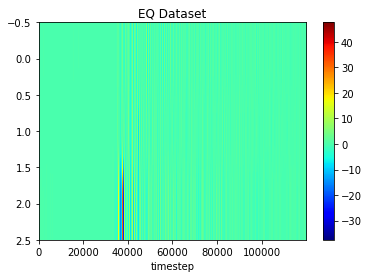

In [3]:
datadir = 'prep_eq_data'
dataset = 'eq_data'
_, (train_data, test_data), _ = dataset_factory(datadir, dataset)

plt.figure('EQ Dataset')
plt.imshow(torch.cat((train_data, test_data)).squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('EQ Dataset')
plt.xlabel('timestep')
plt.colorbar()

In [4]:
print(train_data.shape)
print(test_data.shape)

torch.Size([60000, 3, 1])
torch.Size([60000, 3, 1])


## Training

In [5]:
#run train_stnn.py --dataset heat --outputdir output_heat --manualSeed 2021 --xp stnn

In [6]:
#run train_stnn.py --dataset heat --outputdir output_heat --manualSeed 5718 --xp stnn_r --mode refine --patience 800 --l1_rel 1e-8

In [9]:
run train_stnn.py --datadir prep_eq_data --dataset eq_data --outputdir output_eq --manualSeed 9690 --xp stnn_d --mode discover --patience 1000 --l1_rel 3e-6 --device 0 --nepoch 25

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'output_eq\\stnn_d'

## Model

In [10]:
outputdir = 'output_eq'
#exps = ['stnn', 'stnn_r', 'stnn_d']
exps = ['stnn_d']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_data, test_data), relations = dataset_factory(datadir, dataset, config['khop'])

    model = SaptioTemporalNN(relations, 3, 60000, 1, config['nz'], config['mode'], config['nhid'],
                             config['nlayers'], config['dropout_f'], config['dropout_d'],
                             config['activation'], config['periode'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [11]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction, _ = model.generate(60000)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
    print('RMSE {}:\t'.format(exp), mse)

RMSE stnn_d:	 1.8244986534118652


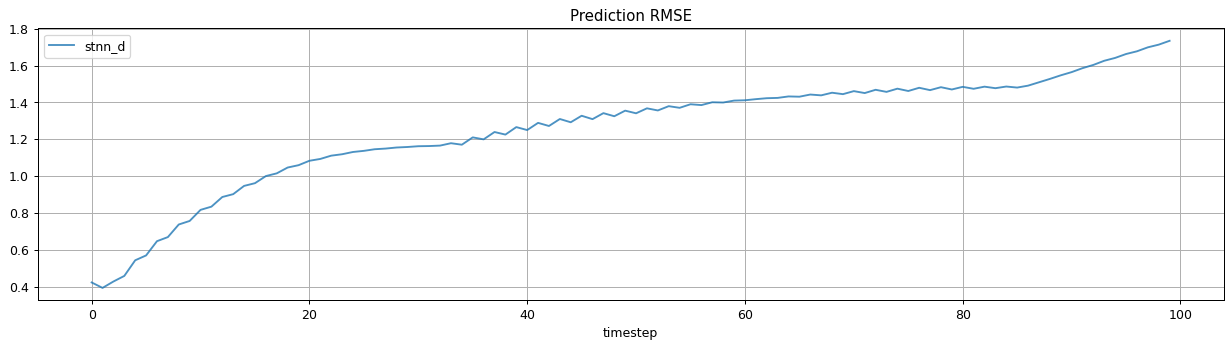

In [12]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(100)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

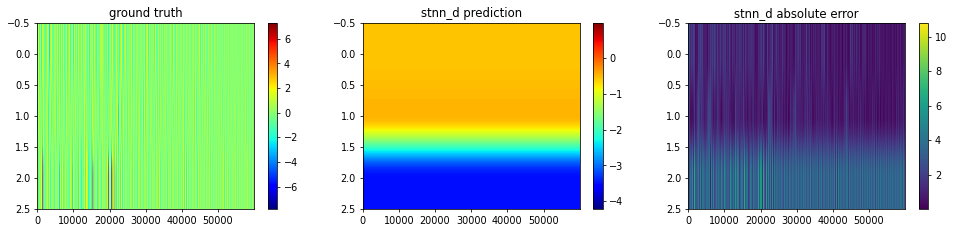

In [13]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))

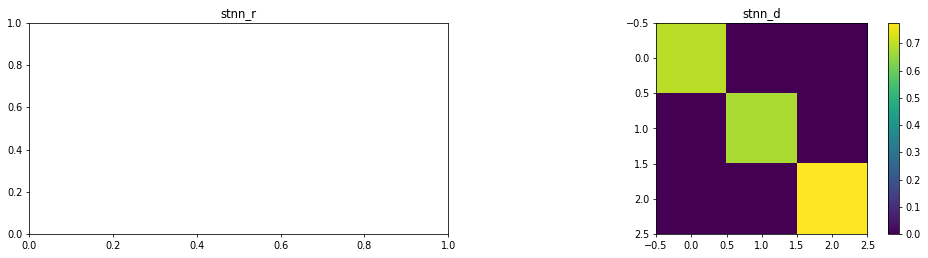

In [14]:
plt.figure('Relations', figsize=(17, 4), dpi=70)

plt.subplot(1, 2, 1)
#m = models['stnn_r']
#plt.imshow(m.get_relations()[:, 1].detach().numpy(), aspect='equal')
plt.title('stnn_r')
#plt.colorbar()

plt.subplot(1, 2, 2)
m = models['stnn_d']
plt.imshow(m.get_relations()[:, 1].detach().numpy(), aspect='equal')
plt.title('stnn_d')
plt.colorbar()